# **Projeto Final: Inteligência Artificial**

Este projeto tem por objetivo desenvolver um algoritmo de Machine Learning para prever a tendência de uma pessoa desenvolver algum tipo de doença cardíaca com base em alguns fatores clínicos e laboratoriais.

**Equipe:** Ryan Soares, Luiz Neto e Gabriel Domingos


In [1]:
# type: ignore
# Bibliotecas essenciais
import warnings
import numpy as np
import pandas as pd

# Configurações
warnings.filterwarnings("ignore")

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
from tabulate import tabulate

# Machine Learning - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Machine Learning - Pré-processamento e avaliação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep Learning (Keras & TensorFlow)
from keras.models import Sequential  # type: ignore
from keras.layers import Dense  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Importação dos dados
data = pd.read_csv('heart.csv')

In [3]:
# Primeira vizualização
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Quantidade de linhas e colunas
data.shape

(303, 14)

## 📊 Análise Exploratória de Dados

---



## 🔍 **Colunas Categóricas**
As colunas categóricas serão analisadas para garantir que todos os valores estejam dentro do domínio esperado. Isso inclui:

- **Identificação de Anomalias**: Detectar valores fora do padrão (ex.: misspellings, valores nulos, ou categorias não mapeadas).
- **Consistência dos Dados**: Garantir que os valores estejam alinhados com o domínio definido para cada variável.

In [5]:
# Criando os groupbys para as colunas originais
groupby_sex = data.groupby("sex").size().rename("Contagem").reset_index()
groupby_cp = data.groupby("cp").size().rename("Contagem").reset_index()
groupby_fbs = data.groupby("fbs").size().rename("Contagem").reset_index()
groupby_restecg = data.groupby("restecg").size().rename("Contagem").reset_index()
groupby_exang = data.groupby("exang").size().rename("Contagem").reset_index()

# Adicionando rótulos descritivos para as colunas originais
groupby_sex["Sexo"] = groupby_sex["sex"].map({0: "Homem", 1: "Mulher"})
groupby_cp["Tipo de Dor no Peito (CP)"] = groupby_cp["cp"].map({
    0: "Angina típica",
    1: "Angina atípica",
    2: "Dor não anginosa",
    3: "Assintomática"
})
groupby_fbs["Glicemia em Jejum (FBS)"] = groupby_fbs["fbs"].map({0: "Normal", 1: "Alta"})
groupby_restecg["Eletrocardiograma (RestECG)"] = groupby_restecg["restecg"].map({
    0: "Normal",
    1: "Anormalidade na onda ST-T",
    2: "Hipertrofia ventricular esquerda"
})
groupby_exang["Angina Induzida (Exang)"] = groupby_exang["exang"].map({0: "Não", 1: "Sim"})

# Selecionando apenas as colunas de interesse dos groupbys originais
groupby_sex = groupby_sex[["Sexo", "Contagem"]]
groupby_cp = groupby_cp[["Tipo de Dor no Peito (CP)", "Contagem"]]
groupby_fbs = groupby_fbs[["Glicemia em Jejum (FBS)", "Contagem"]]
groupby_restecg = groupby_restecg[["Eletrocardiograma (RestECG)", "Contagem"]]
groupby_exang = groupby_exang[["Angina Induzida (Exang)", "Contagem"]]

# Criando os groupbys para as novas colunas

# Para slope
groupby_slope = data.groupby("slope").size().rename("Contagem").reset_index()
groupby_slope["Inclinação (Slope)"] = groupby_slope["slope"].map({
    0: "Inclinação 1",
    1: "Inclinação 2",
    2: "Inclinação 3"
})
groupby_slope = groupby_slope[["Inclinação (Slope)", "Contagem"]]

# Para ca
groupby_ca = data.groupby("ca").size().rename("Contagem").reset_index()
groupby_ca["Número de Vasos (CA)"] = groupby_ca["ca"]
groupby_ca = groupby_ca[["Número de Vasos (CA)", "Contagem"]]

# Para thal
groupby_thal = data.groupby("thal").size().rename("Contagem").reset_index()
groupby_thal["Resultado do teste de estresse de tálio (Thal)"] = groupby_thal["thal"].map({
    0: "Normal",
    1: "Defeito Fixo",
    2: "Defeito Reversível",
    3: "Sem descrição"
})
groupby_thal = groupby_thal[["Resultado do teste de estresse de tálio (Thal)", "Contagem"]]

# Para target
groupby_target = data.groupby("target").size().rename("Contagem").reset_index()
groupby_target["Diagnóstico (Target)"] = groupby_target["target"].map({
    0: "Sem doença",
    1: "Com doença"
})
groupby_target = groupby_target[["Diagnóstico (Target)", "Contagem"]]

# Juntando todos os resultados em um único DataFrame
resultados = pd.concat(
    [groupby_sex, groupby_cp, groupby_fbs, groupby_restecg, groupby_exang,
     groupby_slope, groupby_ca, groupby_thal, groupby_target],
    axis=1
)

# Substituindo NaN por string vazia (para melhor visualização)
resultados = resultados.fillna("")

# Exibindo os resultados lado a lado
display(HTML(resultados.to_html(index=False)))


Sexo,Contagem,Tipo de Dor no Peito (CP),Contagem,Glicemia em Jejum (FBS),Contagem,Eletrocardiograma (RestECG),Contagem,Angina Induzida (Exang),Contagem,Inclinação (Slope),Contagem,Número de Vasos (CA),Contagem,Resultado do teste de estresse de tálio (Thal),Contagem,Diagnóstico (Target),Contagem
Homem,96.0,Angina típica,143.0,Normal,258.0,Normal,147.0,Não,204.0,Inclinação 1,21.0,0,175,Normal,2.0,Sem doença,138.0
Mulher,207.0,Angina atípica,50.0,Alta,45.0,Anormalidade na onda ST-T,152.0,Sim,99.0,Inclinação 2,140.0,1,65,Defeito Fixo,18.0,Com doença,165.0
,,Dor não anginosa,87.0,,,Hipertrofia ventricular esquerda,4.0,,,Inclinação 3,142.0,2,38,Defeito Reversível,166.0,,
,,Assintomática,23.0,,,,,,,,,3,20,Sem descrição,117.0,,
,,,,,,,,,,,,4,5,,,,


In [6]:
# Criação de gráficos para vizualização das colunas categóricas
# Colunas
colunas = ["cp", "sex", "fbs", "exang", "restecg", "slope", "ca", "thal", "target"]

# Criação dos mapeamentos para rótulos
mapeamentos = {
    "sex": {
        0: "Homem",
        1: "Mulher"
    },
    "cp": {
        0: "Angina típica",
        1: "Angina atípica",
        2: "Dor não anginosa",
        3: "Assintomática"
    },
    "fbs": {
        0: "Glicose Normal",
        1: "Glicose Alta"
    },
    "exang": {
        0: "Não",
        1: "Sim"
    },
    "restecg": {
        0: "Normal",
        1: "Anormalidade\nST-T",
        2: "Hipertrofia Ventricular\nEsquerda (provável/definitiva)"
    },
    # Para ca, usamos os próprios valores (convertidos para string)
    "ca": {val: str(val) for val in sorted(data["ca"].unique())},
    "thal": {
      0: "Normal",
      1: "Defeito Fixo",
      2: "Defeito Reversível",
      3: "Sem descrição"
    },
    "target": {
        0: "Sem doença",
        1: "Com doença"
    },
    "slope": {
    0: "Inclinação 1",
    1: "Inclinação 2",
    2: "Inclinação 3"
    }
}

# Cria subplots: utilizando 2 linhas e 5 colunas para acomodar as 10 variáveis
fig = make_subplots(
    rows=2,
    cols=5,
    subplot_titles=[f"Distribuição de {col.upper()}" for col in colunas],
    vertical_spacing=0.15,
    horizontal_spacing=0.07
)

# Geração dos gráficos para cada coluna
for idx, coluna in enumerate(colunas, 1):
    # Cálculo da posição do subplot (linha e coluna)
    row = (idx - 1) // 5 + 1
    col_plot = (idx - 1) % 5 + 1

    # Contagem de cada categoria
    contagem = data[coluna].value_counts().sort_index()

    # Se houver mapeamento definido, usa-o; caso contrário, mantém o valor original
    if coluna in mapeamentos:
        categorias = contagem.index.map(mapeamentos[coluna])
    else:
        categorias = contagem.index.astype(str)

    df = pd.DataFrame({
        "Categoria": categorias,
        "Frequência": contagem.values
    })

    # Define range do eixo Y com folga de 10%
    max_valor = contagem.max() * 1.1

    # Cria gráfico de barras
    barra = px.bar(
        df,
        x="Categoria",
        y="Frequência",
        text="Frequência",
        color="Categoria",
        template="plotly_dark"
    ).update_traces(
        texttemplate="%{y:,}",
        textposition="outside",
        textfont_size=12,
        marker_line=dict(width=1, color="White"),
        cliponaxis=False,  # evita cortar o texto fora do eixo
        width=0.9
    )

    # Adiciona o gráfico ao subplot correspondente
    for trace in barra.data:
        fig.add_trace(trace, row=row, col=col_plot)

    # Ajuste dos eixos
    fig.update_xaxes(
        title_text="",
        tickangle=-30,
        tickfont=dict(size=10),
        row=row,
        col=col_plot,
        showgrid=False,
        automargin=True
    )
    fig.update_yaxes(
        title_text="Contagem" if col_plot == 1 else "",
        row=row,
        col=col_plot,
        showgrid=False,
        range=[0, max_valor],
        automargin=True
    )

# Layout final
fig.update_layout(
    title={
        'text': "📊 Análise de Variáveis Categóricas",
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'color': 'white'}
    },
    showlegend=False,
    width=1200,
    height=900,
    margin=dict(t=120, b=50, l=50, r=50),
    paper_bgcolor="rgba(0,0,0,0.3)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(family="Arial", size=12, color="white"),
    bargap=0.05,
    bargroupgap=0.05
)

fig.show()


### **Conclusão**

Após a análise das colunas categóricas, podemos concluir que:

- **Nenhum dado fora do dominio**: Todos os valores estão dentro do domínio esperado para cada coluna.
  
  - **Exemplo**: Na coluna `sex`, os únicos valores presentes são **"Homem"** e **"Mulher"**. Caso houvesse um valor fora do domínio, como **"Outros"**, seria necessário realizar um tratamento, como substituir pelo valor mais frequente (moda) da coluna.

- **Dados de baixa ocorrência**:
  
  - Na coluna `restecg`, o dado **"Hipertrofia Ventricular Esquerda (provável/definitiva)"** aparece apenas 4 vezes. Recomenda-se sua substituição pela moda da coluna.
  
  - Na coluna `ca`, o valor **4** aparece somente 5 vezes. Também é sugerida a substituição pela moda.
  
  - Na coluna `thal`, o dado **"normal"** aparece apenas 2 vezes, indicando igualmente a necessidade de substituição pela moda.


### **Tratamento dos Dados**

In [ ]:
# Coluna restecg
data.loc[data["restecg"] == 2, "restecg"] = 1 # Troca de dado de baixa ocorrência pela moda

In [8]:
# Análisando novo dominio dos dados
data.groupby(data["restecg"]).size()

restecg
0    147
1    156
dtype: int64

In [9]:
# Coluna ca
data.loc[data["ca"] == 4, "ca"] = 0 # Troca de dado de baixa ocorrência pela moda

In [10]:
# Análisando nova dominio dos dados
data.groupby(data["ca"]).size()

ca
0    180
1     65
2     38
3     20
dtype: int64

In [11]:
# Coluna thal
data.loc[data["thal"] == 0, "thal"] = 2 # Troca de dado de baixa ocorrência pela moda

In [12]:
# Análisando novo dominio dos dados
data.groupby(data["thal"]).size()

thal
1     18
2    168
3    117
dtype: int64

## 🔍 **Colunas Numéricas**

In [13]:
# Vizualização geral das colunas numéricas
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.514851,149.646865,0.326733,1.039604,1.399340,0.663366,2.326733,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.500606,22.905161,0.469794,1.161075,0.616226,0.934375,0.583020,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,1.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [14]:
# Coluna trestbps

# Exibe as estatísticas de 'trestbps' no console
desc_trestbps = data["trestbps"].describe()
display(HTML("<span style='color: lightblue;'>Estatísticas de [trestbps]:</span>"))
print(desc_trestbps)
display(HTML("<span style='color: lightblue;'>Gráficos:</span>"))
# Cria uma figura com 3 subplots (1 linha, 3 colunas)
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=["Boxplot", "Histograma", "Scatter Plot"]
)

# ========== 1) BOXPLOT ==========
box_fig = px.box(
    data,
    y="trestbps",
    template="plotly_dark",
    labels={"trestbps": "Pressão em Repouso"}
)
# Adiciona o boxplot ao subplot (coluna 1)
for trace in box_fig.data:
    fig.add_trace(trace, row=1, col=1)

# ========== 2) HISTOGRAMA ==========
hist_fig = px.histogram(
    data,
    x="trestbps",
    nbins=20,  # Ajuste o número de bins conforme desejar
    template="plotly_dark",
    labels={"trestbps": "Pressão em Repouso"}
)
# Adiciona o histograma ao subplot (coluna 2)
for trace in hist_fig.data:
    fig.add_trace(trace, row=1, col=2)

# ========== 3) SCATTER PLOT ==========
# Exemplo de scatter plot relacionando 'trestbps' com 'age'
# Ajuste para outra coluna caso deseje analisar outra correlação
scatter_fig = px.scatter(
    data,
    x="age",
    y="trestbps",
    template="plotly_dark",
    labels={"age": "Idade", "trestbps": "Pressão em Repouso"}
)
# Adiciona o scatter plot ao subplot (coluna 3)
for trace in scatter_fig.data:
    fig.add_trace(trace, row=1, col=3)

# Ajustes de layout gerais
fig.update_layout(
    title={
        "text": "Boxplot, Histograma e Scatter Plot de Trestbps",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20, "color": "white"}
    },
    showlegend=False,
    width=1200,
    height=600,
    margin=dict(t=80, b=40, l=40, r=40),
    paper_bgcolor="rgba(0,0,0,0.3)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(family="Arial", size=12, color="white")
)

# Ajustes específicos nos eixos de cada subplot
# (opcional: remover grids, ajustar ângulos, etc.)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Exibe o gráfico
fig.show()


count    303.000000
mean     131.623762
std       17.538143
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64


### **Conclusão**

Após a análise da coluna **trestbps** (pressão arterial em repouso), podemos concluir que:

- **Nenhum dado discrepante foi encontrado**: Não há outliers alarmantes que precisem ser removidos, considerando que, no contexto, existem pessoas com pressão arterial de até **200**. Caso houvesse um outlier extremamente discrepante, seria necessário realizar um tratamento, como substituir o valor pela **média**, **mediana** ou até mesmo removê-lo.

In [15]:
# Coluna chol

import plotly.express as px
from plotly.subplots import make_subplots

# Exibe as estatísticas de 'chol' no console
desc_chol = data["chol"].describe()
display(HTML("<span style='color: lightblue;'>Estatísticas de [chol]:</span>"))
print(desc_chol)
display(HTML("<span style='color: lightblue;'>Gráficos:</span>"))

# Cria uma figura com 3 subplots (1 linha, 3 colunas)
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=["Boxplot", "Histograma", "Scatter Plot"]
)

# ========== 1) BOXPLOT ==========
box_fig = px.box(
    data,
    y="chol",
    template="plotly_dark",
    labels={"chol": "Colesterol"}
)
# Adiciona o boxplot ao subplot (coluna 1)
for trace in box_fig.data:
    fig.add_trace(trace, row=1, col=1)

# ========== 2) HISTOGRAMA ==========
hist_fig = px.histogram(
    data,
    x="chol",
    nbins=20,  # Ajuste o número de bins conforme desejar
    template="plotly_dark",
    labels={"chol": "Colesterol"}
)
# Adiciona o histograma ao subplot (coluna 2)
for trace in hist_fig.data:
    fig.add_trace(trace, row=1, col=2)

# ========== 3) SCATTER PLOT ==========
# Exemplo de scatter plot relacionando 'chol' com 'age'
scatter_fig = px.scatter(
    data,
    x="age",
    y="chol",
    template="plotly_dark",
    labels={"age": "Idade", "chol": "Colesterol"}
)
# Adiciona o scatter plot ao subplot (coluna 3)
for trace in scatter_fig.data:
    fig.add_trace(trace, row=1, col=3)

# Ajustes de layout gerais
fig.update_layout(
    title={
        "text": "Boxplot, Histograma e Scatter Plot de Colesterol",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20, "color": "white"}
    },
    showlegend=False,
    width=1200,
    height=600,
    margin=dict(t=80, b=40, l=40, r=40),
    paper_bgcolor="rgba(0,0,0,0.3)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(family="Arial", size=12, color="white")
)

# Ajustes específicos nos eixos de cada subplot
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Exibe o gráfico
fig.show()


count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: chol, dtype: float64


### **Conclusão**

Após a análise da coluna **chol** (Colesterol sérico em mg/dl), podemos concluir que:

- **Outlier Detectado**: Há um valor discrepante na coluna, referente a uma pessoa com colesterol de 564. Embora seja possível, esse valor é bastante raro e se afasta significativamente do restante dos dados. Por isso, recomenda-se sua remoção para evitar que afete negativamente o desempenho do modelo.

### **Tratamento da coluna**

In [16]:
# Remoção de outlier
data = data.loc[data['chol'] != 564]

# Verificando se o mesmo foi removido
print("Outlier removido") if data.loc[data['chol'] == 564].empty else print("Falha ao remover outlier!")

Outlier removido


In [17]:
# Coluna thalach

# Exibe as estatísticas de 'thalach' no console
desc_thalach = data["thalach"].describe()
display(HTML("<span style='color: lightblue;'>Estatísticas de [thalach]:</span>"))
print(desc_thalach)
display(HTML("<span style='color: lightblue;'>Gráficos:</span>"))

# Cria uma figura com 3 subplots (1 linha, 3 colunas)
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=["Boxplot", "Histograma", "Scatter Plot"]
)

# ========== 1) BOXPLOT ==========
box_fig = px.box(
    data,
    y="thalach",
    template="plotly_dark",
    labels={"thalach": "Taxa Cardiaca"}
)
# Adiciona o boxplot ao subplot (coluna 1)
for trace in box_fig.data:
    fig.add_trace(trace, row=1, col=1)

# ========== 2) HISTOGRAMA ==========
hist_fig = px.histogram(
    data,
    x="thalach",
    nbins=20,  # Ajuste o número de bins conforme desejar
    template="plotly_dark",
    labels={"thalach": "Taxa Cardiaca"}
)
# Adiciona o histograma ao subplot (coluna 2)
for trace in hist_fig.data:
    fig.add_trace(trace, row=1, col=2)

# ========== 3) SCATTER PLOT ==========
# Exemplo de scatter plot relacionando 'thalach' com 'age'
scatter_fig = px.scatter(
    data,
    x="age",
    y="thalach",
    template="plotly_dark",
    labels={"age": "Idade", "thalach": "Taxa Cardiaca"}
)
# Adiciona o scatter plot ao subplot (coluna 3)
for trace in scatter_fig.data:
    fig.add_trace(trace, row=1, col=3)

# Ajustes de layout gerais
fig.update_layout(
    title={
        "text": "Boxplot, Histograma e Scatter Plot de Taxa Cardiaca",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20, "color": "white"}
    },
    showlegend=False,
    width=1200,
    height=600,
    margin=dict(t=80, b=40, l=40, r=40),
    paper_bgcolor="rgba(0,0,0,0.3)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(family="Arial", size=12, color="white")
)

# Ajustes específicos nos eixos de cada subplot
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Exibe o gráfico
fig.show()


count    302.000000
mean     149.612583
std       22.935390
min       71.000000
25%      133.250000
50%      152.500000
75%      166.000000
max      202.000000
Name: thalach, dtype: float64


### **Conclusão**

Após a análise da coluna **thalach** (taxa cardíaca máxima obtida durante um teste de estresse), podemos concluir que:

- **Outlier Detectado**: Um outlier foi identificado, mas não é alarmante a ponto de exigir tratamento. No contexto, é possível encontrar pessoas com uma taxa cardíaca de **71** durante o teste de estresse, embora não seja comum, pois a taxa cardíaca geralmente tende a aumentar. Caso houvesse um outlier muito discrepante, seria necessário realizar um tratamento, como substituir o valor pela **média**, **mediana** ou até mesmo removê-lo.


In [18]:
# Coluna oldpeak

# Exibe as estatísticas de 'oldpeak' no console
desc_oldpeak = data["oldpeak"].describe()
display(HTML("<span style='color: lightblue;'>Estatísticas de [oldpeak]:</span>"))
print(desc_oldpeak)
display(HTML("<span style='color: lightblue;'>Gráficos:</span>"))

# Cria uma figura com 3 subplots (1 linha, 3 colunas)
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=["Boxplot", "Histograma", "Scatter Plot"]
)

# ========== 1) BOXPLOT ==========
box_fig = px.box(
    data,
    y="oldpeak",
    template="plotly_dark",
    labels={"oldpeak": "Depressão do ST"}
)
# Adiciona o boxplot ao subplot (coluna 1)
for trace in box_fig.data:
    fig.add_trace(trace, row=1, col=1)

# ========== 2) HISTOGRAMA ==========
hist_fig = px.histogram(
    data,
    x="oldpeak",
    nbins=20,  # Ajuste o número de bins conforme desejar
    template="plotly_dark",
    labels={"oldpeak": "Depressão do ST"}
)
# Adiciona o histograma ao subplot (coluna 2)
for trace in hist_fig.data:
    fig.add_trace(trace, row=1, col=2)

# ========== 3) SCATTER PLOT ==========
# Exemplo de scatter plot relacionando 'oldpeak' com 'age'
scatter_fig = px.scatter(
    data,
    x="age",
    y="oldpeak",
    template="plotly_dark",
    labels={"age": "Idade", "oldpeak": "Depressão do ST"}
)
# Adiciona o scatter plot ao subplot (coluna 3)
for trace in scatter_fig.data:
    fig.add_trace(trace, row=1, col=3)

# Ajustes de layout gerais
fig.update_layout(
    title={
        "text": "Boxplot, Histograma e Scatter Plot da Depressão do segmento ST induzida pelo exercício em relação ao repouso",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20, "color": "white"}
    },
    showlegend=False,
    width=1200,
    height=600,
    margin=dict(t=80, b=40, l=40, r=40),
    paper_bgcolor="rgba(0,0,0,0.3)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(family="Arial", size=12, color="white")
)

# Ajustes específicos nos eixos de cada subplot
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Exibe o gráfico
fig.show()

count    302.000000
mean       1.037748
std        1.162552
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64


### **Conclusão**

Após a análise da coluna **oldpeak** (alteração observada no eletrocardiograma (ECG) durante o exercício), podemos concluir que:

- **Outliers Detectados**: Dados acima do limite superior são considerados raros na prática clínica, pois **depressões do segmento ST superiores a 2 mm** são clinicamente significativas. Para tratar essa coluna, uma abordagem adequada seria estabelecer um limiar e **excluir linhas** com depressões superiores a **4.0 mm**. Isso ajuda a normalizar os dados, e foi comprovado que a **ausência desses outliers melhora o desempenho** dos modelos preditivos, com base em testes comparativos realizados.


### **Tratamento da coluna**

In [19]:
# Filtra as linhas onde os valores de 'oldpeak' são menores ou iguais a 4.0
data = data.loc[data['oldpeak'] < 4.0]

In [20]:
# Verificando se o mesmo foi removido
print("Outliers removido") if data.loc[data['oldpeak'] > 4.0].empty else print("Falha ao remover outliers!")

Outliers removido


In [21]:
# Busca por valores faltantes (Na´s)
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## **Preparativos para os Modelos**

In [22]:
# Criação de heatmap para análise da correlação entre as variaveis
corr_matrix = data.corr()

# Criando o heatmap interativo com Plotly Express
fig = px.imshow(
    corr_matrix.round(2),            # Arredondando para 2 casas decimais
    text_auto=True,                  # Exibe valores dentro das células
    color_continuous_scale='RdBu_r', # Escala de cores divergente
    zmin=-1,                         # Mínimo da escala de cores
    zmax=1,                          # Máximo da escala de cores
    title='Matriz de Correlação das Variáveis',
    labels=dict(x="Variáveis", y="Variáveis", color="Correlação"),
    width=900,   # Largura da figura
    height=900   # Altura da figura
)

# Ajustando o layout do gráfico
fig.update_layout(
    title_font_size=24,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis_tickfont_size=14,
    yaxis_tickfont_size=14,
    coloraxis_colorbar=dict(
        title_font_size=16,
        tickfont_size=14
    ),
    margin=dict(l=80, r=80, t=100, b=80)  # Ajuste de margens
)

# Rotacionando os rótulos do eixo X e movendo-os para cima
fig.update_xaxes(side='top', tickangle=45)

# Ajustando o tamanho da fonte dos valores de correlação
fig.update_traces(textfont_size=12)

# Exibindo o gráfico
fig.show()


In [23]:
# Vizualização na celula da correlação das variáveis em relação a variável alvo "target"
corr_matrix = data.corr()
corr_matrix["target"].sort_values(ascending=False)

target      1.000000
thalach     0.415909
cp          0.415453
slope       0.341940
restecg     0.166754
fbs        -0.026752
chol       -0.105491
trestbps   -0.132834
age        -0.225650
sex        -0.295074
thal       -0.369015
oldpeak    -0.427951
exang      -0.434158
ca         -0.446795
Name: target, dtype: float64

## **Engenharia de Atributos**

In [24]:
# Remoção da coluna fbs, visto que a mesma tem pouca influencia no modelo
data.drop(['fbs'], axis=1, inplace=True)


### **Explicação das Alterações**

Decidi remover uma colunas do conjunto de dados que não apresenta influência significativa na variável alvo:

1. **Remoção da coluna `fbs`**  
   - Justificativa: A coluna `fbs` (açúcar no sangue em jejum) não demonstrou influência significativa na variável alvo.

In [25]:
# Dataframe final que será utilizado nos modelos
data.head(5)

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1


In [26]:
# Tamanho do df
data.shape

(294, 13)

In [27]:
# Separando as variáveis independentes (X) e dependente (y)
X = data.iloc[:, :12].values  # Seleciona as primeiras 11 colunas
# Transformação de X para o formato de matriz adicionado um novo eixo (newaxis)
X = X.reshape(X.shape[0], -1)
y = data.iloc[:, 12].values  # Seleciona a coluna 11 (target)

In [28]:
# Variável alvo
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

## **Aplicação dos Modelos de Machine Learning**


### **Regressão Lógistica**

In [29]:
# Separação dos dados em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
# Criação do modelo, treinamento e vizualização dos coeficientes
modelo = LogisticRegression(max_iter=200)

In [31]:
# Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [32]:
# Verificando a interseção do modelo
modelo.intercept_

array([0.1335695])

In [33]:
# Verificando a angulação do modelo
modelo.coef_

array([[ 0.02617044, -1.1533928 ,  0.80822118, -0.01309268, -0.00266547,
         0.58997153,  0.02311284, -0.88945791, -0.55481682,  0.80659828,
        -1.03344787, -1.07712168]])

In [34]:
# Fazer previsões nos dados de teste
y_pred = modelo.predict(X_test)

In [ ]:
# type: ignore
# Relatório de Classificação
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Arredondando valores para 2 casas decimais
df_report_rounded = df_report.round(2)

print("\nRelatório de Classificação:")
print(tabulate(df_report_rounded, headers='keys', tablefmt='pretty'))


Relatório de Classificação:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.93    |  0.81  |   0.87   |  32.0   |
|      1       |   0.87    |  0.95  |   0.91   |  42.0   |
|   accuracy   |   0.89    |  0.89  |   0.89   |  0.89   |
|  macro avg   |    0.9    |  0.88  |   0.89   |  74.0   |
| weighted avg |    0.9    |  0.89  |   0.89   |  74.0   |
+--------------+-----------+--------+----------+---------+


Acurácia: 89.19%


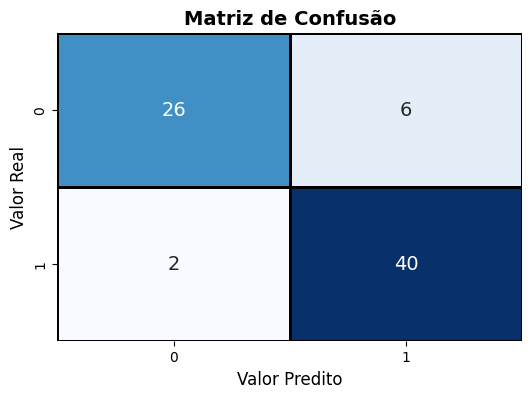

In [36]:
# Plotando a matriz de confusão

# 1. Calcular a acurácia
acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acuracia:.2%}")

# 2. Matriz de Confusão estilizada com seaborn
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=2, linecolor='black')

plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Interpretação da Matriz de Confusão

- **Verdadeiros Negativos (VN):** 26 pessoas que **não tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Verdadeiros Positivos (VP):** 40 pessoas que **tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Falsos Positivos (FP):** 6 pessoas que **não tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que tinham.  
- **Falsos Negativos (FN):** 2 pessoas que **tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que não tinham.  


### **Redes Neurais Artificiais**

In [37]:
# Separação dos dados em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
# Criando um modelo de rede neural sequencial
classifier = Sequential()

# Adicionando a primeira camada oculta com 16 neurônios, ativação ReLU e inicialização uniforme dos pesos
# A camada de entrada possui 12 features (input_dim = 12)
classifier.add(Dense(units=16, activation='relu', kernel_initializer='uniform', input_dim=12))

# Adicionando a segunda camada oculta com 7 neurônios e ativação ReLU
classifier.add(Dense(units=7, activation='relu', kernel_initializer='uniform'))

# Adicionando a camada de saída com 1 neurônio e função de ativação sigmoide, ideal para classificação binária
classifier.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))

# Compilando o modelo usando o otimizador Adam e a função de perda entropia cruzada binária
# O modelo utilizará a métrica de acurácia para avaliar o desempenho
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Resumo do modelo
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335 (1.31 KB)

 Trainable params: 335 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Define o callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', # Monitora a perda no conjunto de validação
                               patience=20,        # Número de epochs para esperar antes de parar se não houver melhora
                               restore_best_weights=True)  # Restaura os pesos do melhor modelo

# Treinamento do modelo
classifier.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_test, y_test),callbacks=[early_stopping])

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4934 - loss: 0.6933 - val_accuracy: 0.5676 - val_loss: 0.6904
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5383 - loss: 0.6902 - val_accuracy: 0.5676 - val_loss: 0.6852
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5167 - loss: 0.6887 - val_accuracy: 0.5676 - val_loss: 0.6789
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5170 - loss: 0.6818 - val_accuracy: 0.5676 - val_loss: 0.6704
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5516 - loss: 0.6684 - val_accuracy: 0.5676 - val_loss: 0.6607
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6414 - loss: 0.6642 - val_accuracy: 0.6622 - val_loss: 0.6515
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6487 - loss: 0.6484 - val_accuracy: 0.6216 - val_loss: 0.6395
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6958 - loss: 0.6224 - val_accuracy: 0.7027 - 

In [41]:
# Previsões do modelo
y_pred = classifier.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
# type: ignore
report = classification_report(y_test, y_pred_binary, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Arredondando valores para 2 casas decimais
df_report_rounded = df_report.round(2)

print("\nRelatório de Classificação:")
print(tabulate(df_report_rounded, headers='keys', tablefmt='pretty'))


Relatório de Classificação:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.96    |  0.78  |   0.86   |  32.0   |
|      1       |   0.85    |  0.98  |   0.91   |  42.0   |
|   accuracy   |   0.89    |  0.89  |   0.89   |  0.89   |
|  macro avg   |   0.91    |  0.88  |   0.89   |  74.0   |
| weighted avg |    0.9    |  0.89  |   0.89   |  74.0   |
+--------------+-----------+--------+----------+---------+


Acurácia: 89.19%


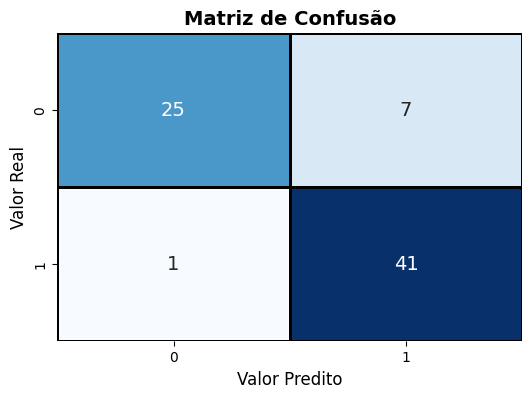

In [43]:
# Plot da matriz de confusão

# 1. Calcular a acurácia
acuracia = accuracy_score(y_test, y_pred_binary)
print(f"Acurácia: {acuracia:.2%}")

# 2. Matriz de Confusão estilizada com seaborn
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=2, linecolor='black')

plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Interpretação da Matriz de Confusão

- **Verdadeiros Negativos (VN):** 24 pessoas que **não tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Verdadeiros Positivos (VP):** 41 pessoas que **tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Falsos Positivos (FP):** 8 pessoas que **não tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que tinham.  
- **Falsos Negativos (FN):** 1 pessoas que **tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que não tinham.  


### **MÁQUINAS DE VETORES DE SUPORTE (SVM)**

In [44]:
# Aplicando padronização nos dados
scaler = StandardScaler()

# Separando as variáveis independentes (X) e dependente (y)
X = data.iloc[:, :12]  # Seleciona as primeiras 11 colunas (índices 0 a 10)
y = data.iloc[:, 12].values  # Seleciona a coluna 11 (target) do DataFrame original

X_norm = StandardScaler().fit_transform(X)
# Verificando as formas de X e y
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (294, 12)
Forma de y: (294,)


In [45]:
# Separação dos dados em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=42)

In [46]:
# Criação da maquina de vetor de suporte
svm = SVC(kernel="rbf", random_state=1, C=2)
svm.fit(X_train, y_train)

SVC(C=2, random_state=1)

In [47]:
svm_results = svm.predict(X_test)
svm_results

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# type: ignore
# Relatório de Classificação
report = classification_report(y_test, svm_results, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Arredondando valores para 2 casas decimais
df_report_rounded = df_report.round(2)

print("\nRelatório de Classificação:")
print(tabulate(df_report_rounded, headers='keys', tablefmt='pretty'))


Relatório de Classificação:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.86    |  0.75  |   0.8    |  32.0   |
|      1       |   0.83    |  0.9   |   0.86   |  42.0   |
|   accuracy   |   0.84    |  0.84  |   0.84   |  0.84   |
|  macro avg   |   0.84    |  0.83  |   0.83   |  74.0   |
| weighted avg |   0.84    |  0.84  |   0.84   |  74.0   |
+--------------+-----------+--------+----------+---------+


Acurácia: 83.78%


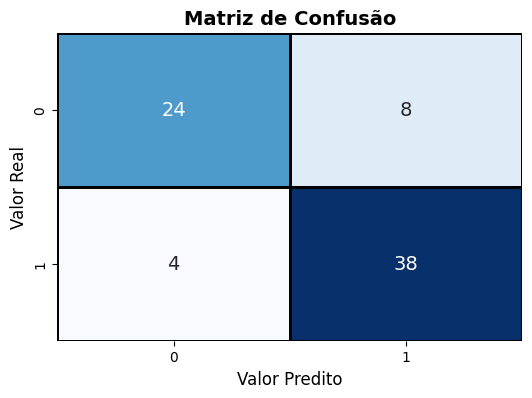

In [49]:
# 1. Calcular a acurácia
acuracia = accuracy_score(y_test, svm_results)
print(f"Acurácia: {acuracia:.2%}")

# 2. Matriz de Confusão estilizada com seaborn
cm = confusion_matrix(y_test, svm_results)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=2, linecolor='black')

plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Interpretação da Matriz de Confusão

- **Verdadeiros Negativos (VN):** 24 pessoas que **não tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Verdadeiros Positivos (VP):** 38 pessoas que **tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Falsos Positivos (FP):** 8 pessoas que **não tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que tinham.  
- **Falsos Negativos (FN):** 4 pessoas que **tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que não tinham.  


### **ÁRVORE DE DECISÃO**

In [50]:
# Separação dos dados em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
# Criação e treino do modelo de árvore de decisão
tree = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [52]:
# Resultados das previsões
tree_results = tree.predict(X_test)
tree_results

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# type: ignore
# Relatório de Classificação
report = classification_report(y_test, tree_results, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Arredondando valores para 2 casas decimais
df_report_rounded = df_report.round(2)

print("\nRelatório de Classificação:")
print(tabulate(df_report_rounded, headers='keys', tablefmt='pretty'))


Relatório de Classificação:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.91    |  0.66  |   0.76   |  32.0   |
|      1       |   0.78    |  0.95  |   0.86   |  42.0   |
|   accuracy   |   0.82    |  0.82  |   0.82   |  0.82   |
|  macro avg   |   0.85    |  0.8   |   0.81   |  74.0   |
| weighted avg |   0.84    |  0.82  |   0.82   |  74.0   |
+--------------+-----------+--------+----------+---------+


Acurácia: 82.43%


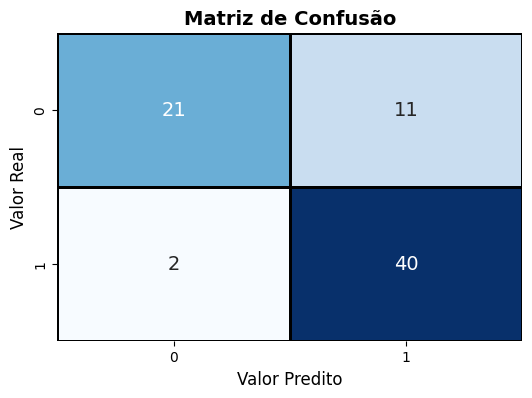

In [54]:
# 1. Calcular a acurácia
acuracia = accuracy_score(y_test, tree_results)
print(f"Acurácia: {acuracia:.2%}")

# 2. Matriz de Confusão estilizada com seaborn
cm = confusion_matrix(y_test, tree_results)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=2, linecolor='black')

plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Interpretação da Matriz de Confusão

- **Verdadeiros Negativos (VN):** 21 pessoas que **não tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Verdadeiros Positivos (VP):** 40 pessoas que **tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Falsos Positivos (FP):** 11 pessoas que **não tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que tinham.  
- **Falsos Negativos (FN):** 2 pessoas que **tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que não tinham.  

### **RANDOM FOREST**

In [55]:
# Separação dos dados em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
# Criação e treinamento do modelo de floresta aleatória
random = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state = 0, max_depth=4)
random.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=150,
                       random_state=0)

In [57]:
# Previsões do modelo
random_predict = random.predict(X_test)
random_predict

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# type: ignore
# Relatório de Classificação
report = classification_report(y_test, random_predict, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Arredondando valores para 2 casas decimais
df_report_rounded = df_report.round(2)

print("\nRelatório de Classificação:")
print(tabulate(df_report_rounded, headers='keys', tablefmt='pretty'))


Relatório de Classificação:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.93    |  0.84  |   0.89   |  32.0   |
|      1       |   0.89    |  0.95  |   0.92   |  42.0   |
|   accuracy   |   0.91    |  0.91  |   0.91   |  0.91   |
|  macro avg   |   0.91    |  0.9   |   0.9    |  74.0   |
| weighted avg |   0.91    |  0.91  |   0.9    |  74.0   |
+--------------+-----------+--------+----------+---------+


Acurácia: 90.54%


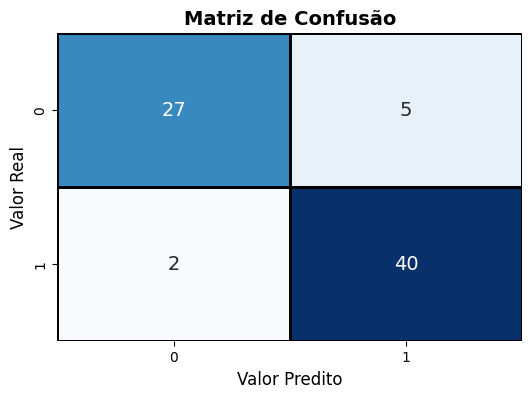

In [59]:
# Plot da matriz de confusão

# 1. Calcular a acurácia
acuracia = accuracy_score(y_test, random_predict)
print(f"Acurácia: {acuracia:.2%}")

# 2. Matriz de Confusão estilizada com seaborn
cm = confusion_matrix(y_test, random_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=2, linecolor='black')

plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Interpretação da Matriz de Confusão

- **Verdadeiros Negativos (VN):** 27 pessoas que **não tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Verdadeiros Positivos (VP):** 40 pessoas que **tinham tendência** de desenvolver doença cardíaca com o tempo, e o modelo classificou corretamente.  
- **Falsos Positivos (FP):** 5 pessoas que **não tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que tinham.  
- **Falsos Negativos (FN):** 2 pessoas que **tinham tendência** de desenvolver doença cardíaca, mas o modelo previu incorretamente que não tinham.  

## Análise de Modelos de Previsão de Doença Cardíaca

### Divisão dos Dados e Padronização

- **Divisão dos Dados:**
  - 75% para treinamento.
  - 15% para teste.

- **Padronização com Z-score:**
  - Aplicada apenas no modelo SVM, resultando em um ganho considerável de desempenho.
  - Nos testes realizados com Regressão Logística e Redes Neurais, a padronização ocasionou uma perda de desempenho.
  - Os modelos baseados em Floresta Aleatória e Árvore de Decisão não necessitaram da padronização.

### Resultados Obtidos (Holdout)

- **Floresta Aleatória:** 90,54% (67 acertos)
- **Regressão Logística:** 89,19% (66 acertos)
- **Redes Neurais:** 87,84% (65 acertos)
- **Máquinas de Vetores de Suporte (SVM):** 83,78% (62 acertos)
- **Árvore de Decisão:** 82,43% (61 acertos)

### Conclusão

O modelo que apresentou o melhor desempenho na previsão da tendência de uma pessoa desenvolver algum tipo de doença cardíaca, com base em fatores clínicos e laboratoriais, foi a **Floresta Aleatória**. Apesar de todos os modelos terem demonstrado um desempenho satisfatório, a Floresta Aleatória destacou-se como a opção mais eficaz.


## **Demonstração**

In [60]:
# Função para gerar um registro fictício com base nas colunas do dataset
def gerar_dado_ficticio():
    dado = {
        'age': np.random.randint(29, 78),                   # idade entre 29 e 77 anos
        'sex': np.random.choice([0, 1]),                    # 0: feminino, 1: masculino
        'cp': np.random.randint(0, 4),                      # tipo de dor no peito (0 a 3)
        'trestbps': np.random.randint(90, 201),             # pressão arterial de repouso (mm Hg)
        'chol': np.random.randint(150, 400),                # colesterol sérico (mg/dl)
        'restecg': np.random.randint(0, 3),                 # resultados do eletrocardiograma de repouso (0 a 2)
        'thalach': np.random.randint(70, 211),              # frequência cardíaca máxima atingida
        'exang': np.random.choice([0, 1]),                  # angina induzida por exercício (0 ou 1)
        'oldpeak': round(np.random.uniform(0, 6), 1),       # depressão do ST induzida pelo exercício
        'slope': np.random.randint(0, 3),                   # inclinação do segmento ST (0 a 2)
        'ca': np.random.randint(0, 4),                      # número de vasos sanguíneos principais (0 a 3)
        'thal': np.random.choice([3, 6, 7])                 # valor categórico para thal (3: normal, 6: defeito fixo, 7: defeito reversível)
    }
    # Converte o dicionário para um DataFrame (uma única linha)
    return pd.DataFrame([dado])

# Função para prever a presença de doença cardíaca usando o modelo treinado
def prever_doenca_cardiaca(modelo, dado):
    # Aqui, 'dado' deve ser um DataFrame com as mesmas colunas do dataset original
    pred = modelo.predict(dado)
    # Dependendo da codificação do target: 1 (doença) ou 0 (sem doença)
    if pred[0] == 1:
        return "Predição: Possível presença de doença cardíaca."
    else:
        return "Predição: Baixo risco de doença cardíaca."

# Exemplo de uso:
# Supondo que o seu modelo Random Forest treinado esteja na variável 'random'
# Gerar dados fictícios
dado_ficticio = gerar_dado_ficticio()
print("Dados de entrada:")
print(dado_ficticio)

# Realizar a previsão
resultado = prever_doenca_cardiaca(random, dado_ficticio)
print("\n" + resultado)


Dados de entrada:
   age  sex  cp  trestbps  chol  restecg  thalach  exang  oldpeak  slope  ca  \
0   55    0   3       123   348        2      182      1      0.2      2   1   

   thal  
0     7  

Predição: Possível presença de doença cardíaca.
